# Mango Image Classification Using Handcrafted Feature Extraction and Random Forest Classifier

## Overview

This project implements a complete pipeline for **classifying mango images** using a wide range of **handcrafted features** derived from color, texture, and shape information. The classification is performed using a **Random Forest Classifier**, and the approach is fully interpretable and lightweight.

---

## Dataset Structure




Each subfolder represents a mango class (e.g., *ripe*, *unripe*, *diseased*), containing relevant images.

---

## Feature Extraction

### Preprocessing Steps:
- Resize all images to **100×100** pixels.
- Convert each image to:
  - **Grayscale**
  - **HSV**
  - **LAB**

### Extracted Features:
1. **Color Statistics**:
   - RGB: mean, standard deviation, skewness (for each channel)
   - HSV and LAB: mean and standard deviation (for each channel)

2. **Grayscale Intensity**:
   - Mean and standard deviation

3. **Yellow Pixel Percentage**:
   - Percentage of pixels with Hue ∈ [20, 40] in HSV (indicating yellow region)

4. **Dark Pixel Percentage**:
   - Percentage of pixels with Value < 50 in HSV

5. **Local Binary Pattern (LBP)**:
   - Uniform LBP with 10-bin histogram (P=8, R=1)

6. **Edge Density**:
   - Ratio of edge pixels using Canny Edge Detection

7. **Color Histograms**:
   - 16-bin normalized histograms for each RGB channel

8. **Shape Features**:
   - Contour-based: Area, Perimeter, Circularity of the largest contour

9. **Haralick Texture Features**:
   - 13 statistical descriptors from GLCMs (using `mahotas`)



---

## Classification Model

### Model: **Random Forest Classifier**
- Implementation: `scikit-learn`
- Parameters:
  - `n_estimators=100`
  - `random_state=42`

### Preprocessing:
- Feature Standardization using `StandardScaler`

### Evaluation Metrics:
- Accuracy
- Classification Report (Precision, Recall, F1-score)
- Confusion Matrix

---

## Results


> Accuracy: 90.26%

---

## Highlights

- Fully interpretable handcrafted pipeline
- Lightweight, no deep learning required
- Easy to adapt for other fruits or agricultural products

---


## Conclusion

This handcrafted approach to mango classification offers a balance between **performance and interpretability**, making it an ideal choice for real-world applications in agricultural automation, especially where resources are limited.

---


## install mahotas for feature extraction using GLCM

In [1]:
!pip install mahotas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 18.6 MB/s eta 0:00:0000:0100:01


## Feature Extraction and Store: Train and Test Data

### Utility Functions

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy.stats import skew
from skimage.feature import local_binary_pattern
from tqdm import tqdm
import mahotas




def extract_features(image):
    features = []
    image = cv2.resize(image, (100, 100))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv  = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lab  = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # RGB mean, std, skewness
    for i in range(3):
        ch = image[:, :, i].flatten()
        features.extend([np.mean(ch), np.std(ch), skew(ch)])

    # HSV mean + std
    for i in range(3):
        ch = hsv[:, :, i].flatten()
        features.extend([np.mean(ch), np.std(ch)])

    # LAB mean + std
    for i in range(3):
        ch = lab[:, :, i].flatten()
        features.extend([np.mean(ch), np.std(ch)])

    # Gray mean + std
    features.extend([np.mean(gray), np.std(gray)])

    # Yellow percentage
    h, s, v = cv2.split(hsv)
    yellow_pct = np.sum((h > 20) & (h < 40)) / h.size
    features.append(yellow_pct)

    # Dark pixel percentage
    dark_pct = np.sum(v < 50) / v.size
    features.append(dark_pct)

    # LBP texture features
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    features.extend(hist)

    # Edge density
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size
    features.append(edge_density)

    # ===== STEP 1: Color Histograms =====
    for i in range(3):  # R, G, B
        hist = cv2.calcHist([image], [i], None, [16], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.extend(hist)

    # ===== STEP 2: Shape Features =====
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)
        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0
        features.extend([area, perimeter, circularity])
    else:
        features.extend([0, 0, 0])

    # ===== STEP 3: Haralick Texture =====
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    features.extend(haralick)

    return features






In [3]:

def create_feature_csv(data_path, classes, save_path):
    all_data = []
    for cls in classes:
        folder = os.path.join(data_path, cls)
        if not os.path.exists(folder):
            continue
        for file in tqdm(os.listdir(folder), desc=f'Processing {cls}'):
            path = os.path.join(folder, file)
            img = cv2.imread(path)
            if img is not None:
                feats = extract_features(img)
                feats.append(cls)
                all_data.append(feats)


    df = pd.DataFrame(all_data)
    df.columns = [f'feat_{i}' for i in range(df.shape[1]-1)] + ['label']
    df.to_csv(save_path, index=False)
    print(f"Saved to {save_path}")

### Run and Store

In [4]:

train_path = '/kaggle/input/mango-classification-image-dataset/mango_dataset/Dataset/Train'
test_path  = '/kaggle/input/mango-classification-image-dataset/mango_dataset/Dataset/Test'
classes = sorted(os.listdir(train_path))


create_feature_csv(train_path, classes, "train_features.csv")
create_feature_csv(test_path,  classes, "test_features.csv")

Processing Unripe: 100%|██████████| 207/207 [00:05<00:00, 38.69it/s]


Saved to train_features.csv


Processing Unripe: 100%|██████████| 31/31 [00:00<00:00, 37.57it/s]


Saved to test_features.csv


In [5]:
classes

['Early_ripe', 'Partially_ripe', 'Ripe', 'Rotten', 'Unripe']

## Random Forest: Train

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


train_df = pd.read_csv("train_features.csv")
test_df  = pd.read_csv("test_features.csv")


X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]

X_test = test_df.drop("label", axis=1)
y_test = test_df["label"]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)





RandomForestClassifier(random_state=42)

## Evaluate

In [7]:


y_pred = rf.predict(X_test_scaled)


acc = accuracy_score(y_test, y_pred)
print(f"\n Random Forest Accuracy: {acc * 100:.2f}%\n")

print(" Classification Report:")
print(classification_report(y_test, y_pred))

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


 Random Forest Accuracy: 90.26%

 Classification Report:
                precision    recall  f1-score   support

    Early_ripe       0.83      0.65      0.73        31
Partially_ripe       0.86      0.97      0.91        31
          Ripe       1.00      1.00      1.00        31
        Rotten       1.00      1.00      1.00        30
        Unripe       0.82      0.90      0.86        31

      accuracy                           0.90       154
     macro avg       0.90      0.90      0.90       154
  weighted avg       0.90      0.90      0.90       154

 Confusion Matrix:
[[20  5  0  0  6]
 [ 1 30  0  0  0]
 [ 0  0 31  0  0]
 [ 0  0  0 30  0]
 [ 3  0  0  0 28]]



Random Forest Accuracy: 90.26%

Classification Report:
                precision    recall  f1-score   support

    Early_ripe       0.83      0.65      0.73        31
Partially_ripe       0.86      0.97      0.91        31
          Ripe       1.00      1.00      1.00        31
        Rotten       1.00      1.00      1.00        30
        Unripe       0.82      0.90      0.86        31

      accuracy                           0.90       154
     macro avg       0.90      0.90      0.90       154
  weighted avg       0.90      0.90      0.90       154

Confusion Matrix:
[[20  5  0  0  6]
 [ 1 30  0  0  0]
 [ 0  0 31  0  0]
 [ 0  0  0 30  0]
 [ 3  0  0  0 28]]


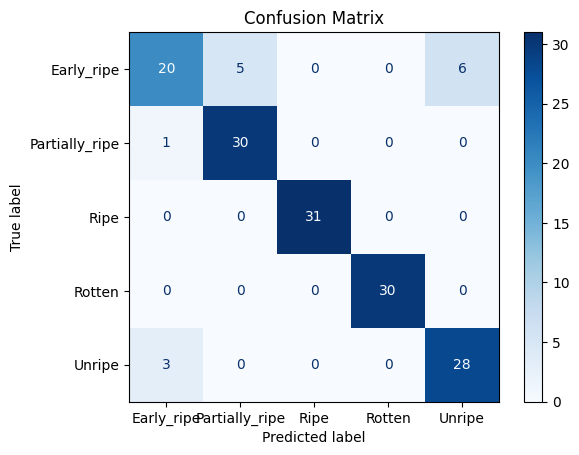

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score

y_pred = rf.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"\nRandom Forest Accuracy: {acc * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


## Save and Test with Random Test Data

In [10]:
import joblib
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [11]:
import cv2
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler


rf = joblib.load("random_forest_model.pkl")
scaler = joblib.load("scaler.pkl")


def predict_image_class(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Failed to load image:", image_path)
        return None

    # Extract features
    features = extract_features(img)
    features = np.array(features).reshape(1, -1)

    # Scale
    features_scaled = scaler.transform(features)

    # Predict
    prediction = rf.predict(features_scaled)[0]
    proba = rf.predict_proba(features_scaled).max()

    print(f"Predicted Class: {prediction} (Confidence: {proba*100:.2f}%)")
    return prediction


In [12]:
predict_image_class("/kaggle/input/mango-classification-image-dataset/mango_dataset/Dataset/Test/Early_ripe/IMG20200713142139.jpg")


Predicted Class: Partially_ripe (Confidence: 43.00%)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


'Partially_ripe'

Visualization

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but 

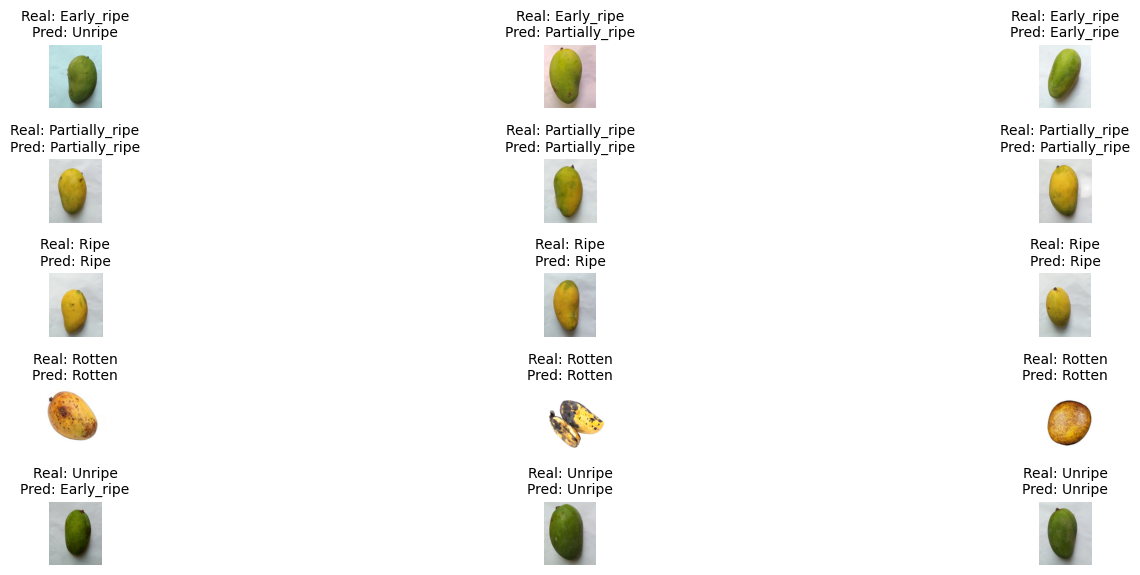

In [14]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib

rf = joblib.load("random_forest_model.pkl")
scaler = joblib.load("scaler.pkl")

test_path = '/kaggle/input/mango-classification-image-dataset/mango_dataset/Dataset/Test'
classes = sorted(os.listdir(test_path))

results = []

for cls in classes:
    folder = os.path.join(test_path, cls)
    if not os.path.isdir(folder):
        continue

    images = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    selected = random.sample(images, min(3, len(images)))

    for img_name in selected:
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            features = extract_features(img)
            features = np.array(features).reshape(1, -1)
            features_scaled = scaler.transform(features)
            pred = rf.predict(features_scaled)[0]
            results.append((img, cls, pred))

plt.figure(figsize=(15, len(results) * 1.5 // 3))
for idx, (img, true_cls, pred_cls) in enumerate(results):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(len(results) // 3 + 1, 3, idx + 1)
    plt.imshow(img_rgb)
    plt.title(f"Real: {true_cls}\nPred: {pred_cls}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()
